# Project Proposal

# Participant: Qimeng Tao(qt2139)

# Video face recognition based on RetinaFace and FaceNet

## THE CREATIVE IDEA AND PROCESS OF THE ALGORITHM

As the professor stated in lecture 2, face recognition is important to us but difficult for computers. Especially in the video field. For example, in lecture 2, we can see that the input to the model is an image, and this image contains only one face (the area of the face exceeds 90% of the image area). Let's look at the widely used face dataset CASIA-WebFace, most of the images contain only human faces. Then for each frame of the video, the image contains a lot of background, and the area of the face is often very small. At this time, when we directly feed each frame in the video into the existing face recognition model, I believe the model will not have very good performance.

## In order to solve this situation, I combine  two models. 

## First Creative Idea

I first use the face detection algorithm(RetinaFace) to detect the face box of each frame in the video and crop it, and then send the cropped image to the face recognition algorithm(FaceNet), and finally get the recognition result. The algorithm flow is shown in Fig 1.

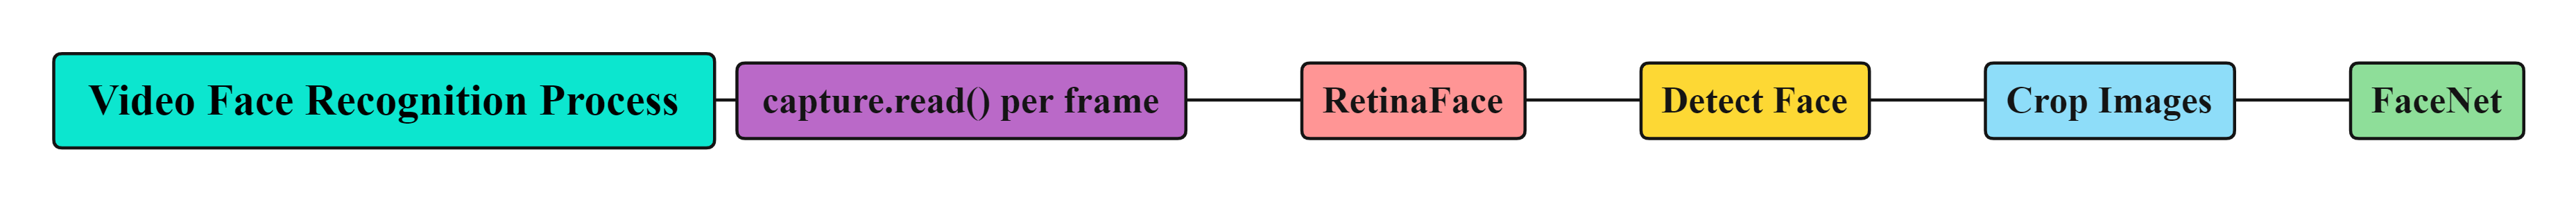

<Figure size 432x288 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('C:/Users/taoqi/Desktop/Video Face Recognition Process.png')
plt.figure('image')
display(img)

## The image cropped by RetinaFace is as follows, which is also the input of the second model, FaceNet.

The image on the left is the input of RetinaFace, and the image on the right is the output of RetinaFace. Finally, I sent the cropped image to FaceNet for face recognition.

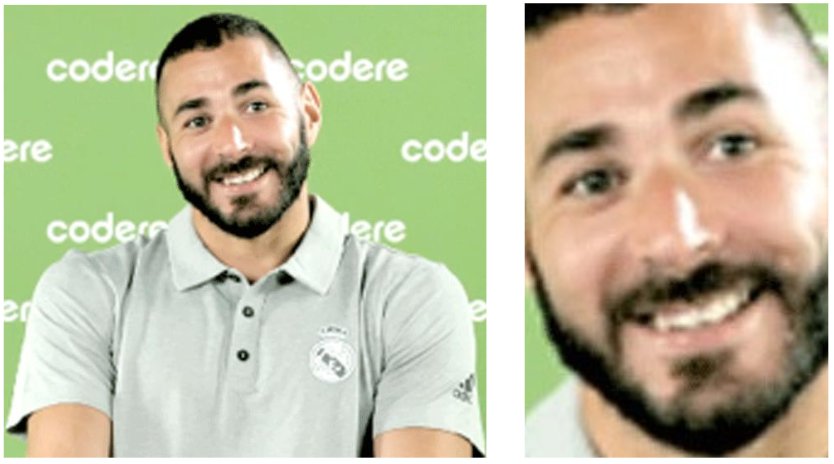

<Figure size 432x288 with 0 Axes>

In [12]:
img = Image.open('C:/Users/taoqi/Desktop/new.png')
plt.figure('image')
display(img)

## Second Creative Idea

To reduce bias, we don't want a tilted human face. So I rotate the image according to the eyes coordinates to get a vertical face.

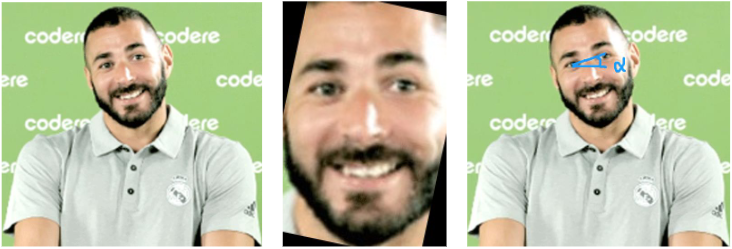

<Figure size 432x288 with 0 Axes>

In [2]:
img = Image.open('C:/Users/taoqi/Desktop/alignment.png')
plt.figure('image')
display(img)

### The above steps are for image face recognition. My ultimate goal is to do face recognition on video.

We know that most videos are 30 frames per second. At this time, we can use OpenCV's capture.read() function to read each frame in the video and send each frame to the model as a picture. Finally, we combine the results of the face recognition model, so that we can get the desired results.

## Third Creative Idea

When the model is inferring, there is also a return result that specifies the time interval in which the person appears in the video. For example, a person appears at frames [0, 60], [80, 120].

In fact, we can return [0, 1, 2, 3,...58, 59, 60, 80, 81,...,119, 120]. Obviously, this is not intuitive. And when the model is misdetected, there will be breakpoints, such as [0, 2, 4, 8, 10]. But in real situations, at the 1st, 3rd, 5th, 7th, and 9th frames, the characters appear in in the video. At this point, I set up a little trick. When the model does not detect a person, I will record the current index first, and then continue to detect. If the person is detected within 10 consecutive frames, I ignore the false detection at that time. In contrast, we did not detect the person in the i-th frame, and did not detect the person in the last 5 consecutive frames, then a reasonable interval is [,i].

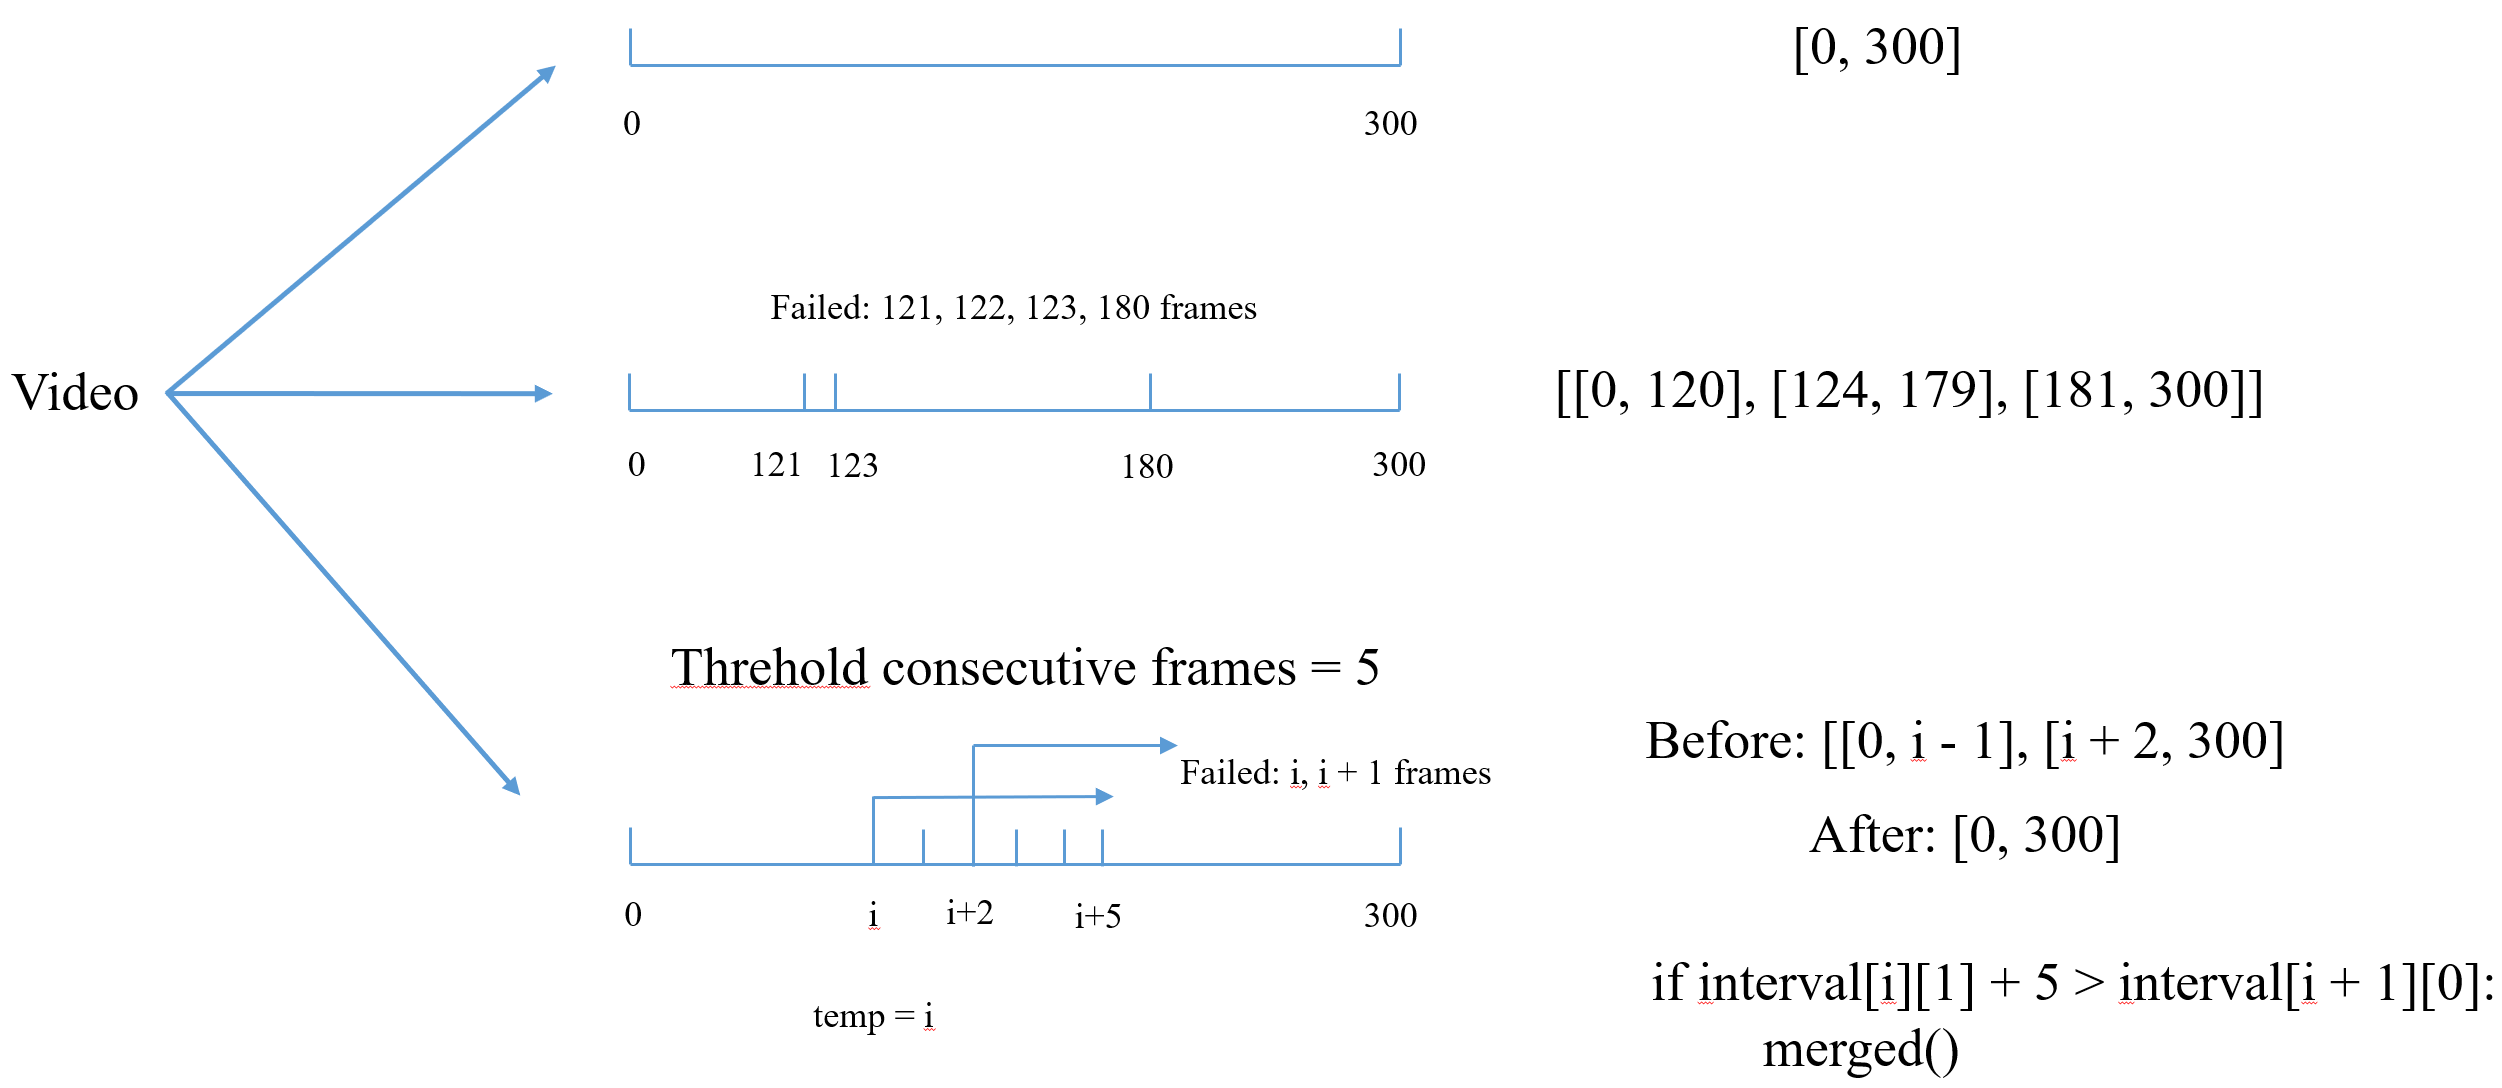

<Figure size 432x288 with 0 Axes>

In [4]:
img = Image.open('C:/Users/taoqi/Desktop/merge.png')
plt.figure('image')
display(img)

Let's look at pseudocode for this idea.

In [ ]:
fps = 0.0
num = 0
n = []
res = False
left = False
temp = []
while (True):
        t1 = time.time()
        # read a frame
        ref, frame = capture.read()
        if not ref:
            break
        # Format conversion, BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # detect
        frame, q = retinaface.detect_image(frame)
        #print(q)
        frame = np.array(frame)
        if 'benzema' in q: # people in video
            res = True
        else:
            res = False # people not in video
        #temp.append(res)
        #print(res)
        # results is intervals, such as [10, 16, 22, 28, 32, 40], which means in [[10, 16], [22, 28], [32,40]] frames detect that people
        if res and not left: # if we have not detected the left intervals
            left = True # we set left = True
            n.append(num) # just like 10, 22, 32(index % 2 == 0) in examples [10, 16, 22, 28, 32, 40]
        elif not res and left: # when we have detect the interval's left boundary
            n.append(num - 1) # just like 16, 28, 40(index % 2 == 1) in examples [10, 16, 22, 28, 32, 40]
            left = False 
        #print(name)
        # Format conversion, RGB to BGR
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        # Calculate FPS
        # Make sure not to divide by 0
        # print(time.time() - t1)
        a = time.time() - t1
        if a == 0:
            a = 0.0001
        fps = (fps + (1. / a)) / 2
        #print("fps= %.2f" % (fps))
        frame = cv2.putText(frame, "fps= %.2f" % (fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("video", frame)

        #print(num)
        c = cv2.waitKey(1) & 0xff
        if video_save_path != "":
            out.write(frame)

        if c == 27:
            capture.release()
            break
        num += 1
    print(num)
    if res and left:
        n.append(int(capture.get(7)) - 2)
    lis = []
    print(n)
    #print(int(capture.get(7)) - 1)
    left, right = 0, 1
    while left < len(n) - 1 and right < len(n): # now we merge the intervals
        #lis.append(n[left])
        while right < len(n) - 2 and n[right] + 10 > n[right + 1]: # If the person is detected in 10 consecutive frames
            right += 2 # merge the intervals, exmaple: [10, 16, 22, 28, 32, 40] -> [10, 40]
        lis.append([n[left], n[right]])
        left = right + 1
        right = left + 1
    print(lis)

## INTRODUCTION TO DATASETS

In this project, I will use two datasets, WIDER FACE and LFW (Labeled Faces in the Wild Home), WIDER FACE is used to train RetinaFace, and CASIA-WebFace is used to train FaceNet.

### WIDER FACE

The WIDER FACE dataset is a face detection dataset produced by the Chinese University of Hong Kong, containing 32,203 images and 393,703 labeled faces. Among them, there are 158,989 labeled faces in the training set and 39,496 face images in the validation set. Each subset contains 3 levels of detection difficulty: Easy, Medium, Hard. Since the dataset brings together various influencing factors such as face size changes, face pose changes caused by camera angles, different degrees of face occlusion, expression changes, differences in light intensity and makeup, this dataset is widely used in global face detection. The field is extremely challenging. We can download the dataset directly from the official website.

I uploaded the dataset to Google Drive.

https://drive.google.com/drive/folders/1vmovv8juHdq808FBqklwzfhIwjRlP3GQ

### CASIA-WebFace

The CASIA-WebFace dataset is used for face recognition tasks. The dataset contains 494,414 face images of 10,575 real identities collected from the web.

I uploaded the dataset to Google Drive.

https://drive.google.com/drive/folders/1vmovv8juHdq808FBqklwzfhIwjRlP3GQ

## FACE DETECTION - RETINAFACE

First, I will use a face detection algorithm to detect the faces in the picture and crop the faces according to the coordinates. Regarding the face detection algorithm, in this project, I will use RetinaFace. I used RetinaFace because RetinaFace is a one-stage detection algorithm, and its inference speed will be very fast. Second, I found that Easy, Medium, and Hard in the dataset correspond to the proportion of face area and image area, respectively. When the face area is larger, its difficulty is easier. Therefore, we should focus more on the Easy part. Because for the Hard part, the face area is relatively small. Even humans are difficult to identify. In the part of the Easy, Medium dataset, the model has good performance, it can achieve over 96$\%$ accuracy in the WIDERFACE validation subset.

### Introduction to Backbone

In the paper, the author gave two backbones, the first is ResNet-152 and the second is MobileNet-0.25. The model can achieve higher accuracy when we use ResNet-152 as the backbone. But as we all know, inference speed is also a very important metrics. Using MobilenetV1-0.25 as the backbone will indeed reduce some accuracy, but the inference speed will be greatly improved. And the performance of the network is also good enough when using MobileNet-0.25. So I choose MobileNet-0.25 as the backbone in the project.

### MobilenetV1-0.25

MobileNet is a network proposed by the Google team in 2016, which uses Depthwise Convolution to build lightweight deep neural networks. In the network, each channel in the feature map is only convolved with each channel of the Depthwise convolution. This can greatly reduce the parameters, but only using Depthwise convolution can not change the number of channels. To this end, we are using a Pointwise Convolution, and the size of the convolution kernel of Pointwise Convolution is 1 * 1 * n. After Pointwise Convolution, we can change the number of channels to n. Figure is the network structure of MobileNet.

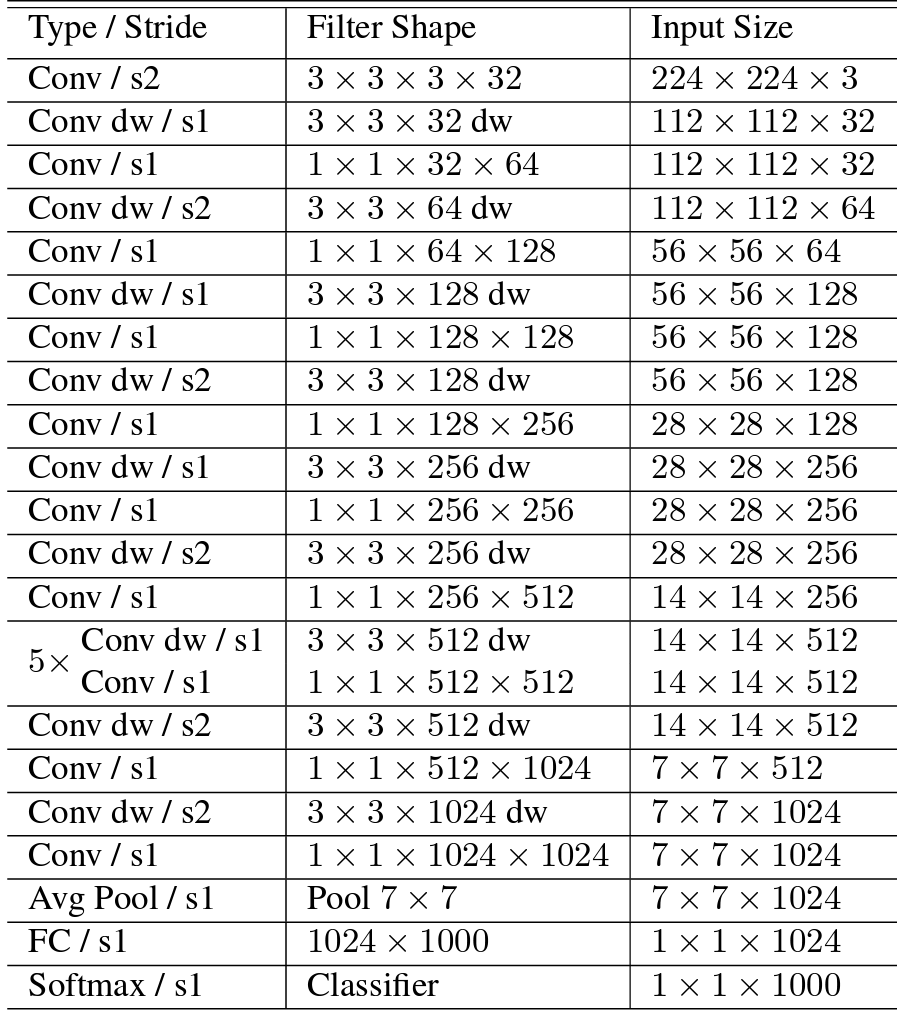

<Figure size 432x288 with 0 Axes>

In [3]:
img = Image.open('C:/Users/taoqi/Desktop/MobileNet.png')
plt.figure('image')
display(img)

Table shows the network architecture of mobilenetV1-1. In the project I used mobilenetV1-0.25, which differs from mobilenetV1-1 in that the number of all channels is compressed to 1/4 of the original number. The authors evaluated the model on ImageNet and the experimental results are shown in Table below. As can be seen from Table, the performance of the model is not good compared to more complex networks, but there is a great improvement in the inference speed. The use of mobilenetV1-0.25 is sufficient, especially considering that we are more concerned with larger face areas in our project.

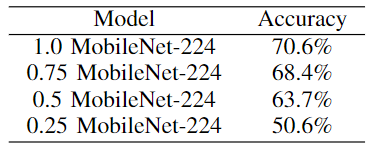

<Figure size 432x288 with 0 Axes>

In [4]:
img = Image.open('C:/Users/taoqi/Desktop/mobileacc.png')
plt.figure('image')
display(img)

Let's reproduce the MobileNet code.

In [5]:
import torch.nn as nn

def conv_bn(inp, oup, stride = 1, leaky = 0.1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )
    
def conv_dw(inp, oup, stride = 1, leaky=0.1):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope= leaky,inplace=True),
    )

class MobileNetV1(nn.Module):
    def __init__(self):
        super(MobileNetV1, self).__init__()
        self.stage1 = nn.Sequential(
            # 640,640,3 -> 320,320,8
            conv_bn(3, 8, 2, leaky = 0.1),
            # 320,320,8 -> 320,320,16
            conv_dw(8, 16, 1),

            # 320,320,16 -> 160,160,32
            conv_dw(16, 32, 2),
            conv_dw(32, 32, 1),

            # 160,160,32 -> 80,80,64
            conv_dw(32, 64, 2),
            conv_dw(64, 64, 1),
        )
        # 80,80,64 -> 40,40,128
        self.stage2 = nn.Sequential(
            conv_dw(64, 128, 2), 
            conv_dw(128, 128, 1), 
            conv_dw(128, 128, 1), 
            conv_dw(128, 128, 1), 
            conv_dw(128, 128, 1), 
            conv_dw(128, 128, 1), 
        )
        # 40,40,128 -> 20,20,256
        self.stage3 = nn.Sequential(
            conv_dw(128, 256, 2), 
            conv_dw(256, 256, 1),
        )
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(256, 1000)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.avg(x)
        # x = self.model(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x


### Feature Pyramid Network

For example, target detection algorithms such as YOLO, RetinaFace also builds a feature pyramid. As shown in the figure, after C3, C4, and C5, the number of channels is adjusted by 1 * 1 convolution, and then fusion the feature by Upsample and Add. Finally, we obtained three effective feature layers P3, P4, and P5.

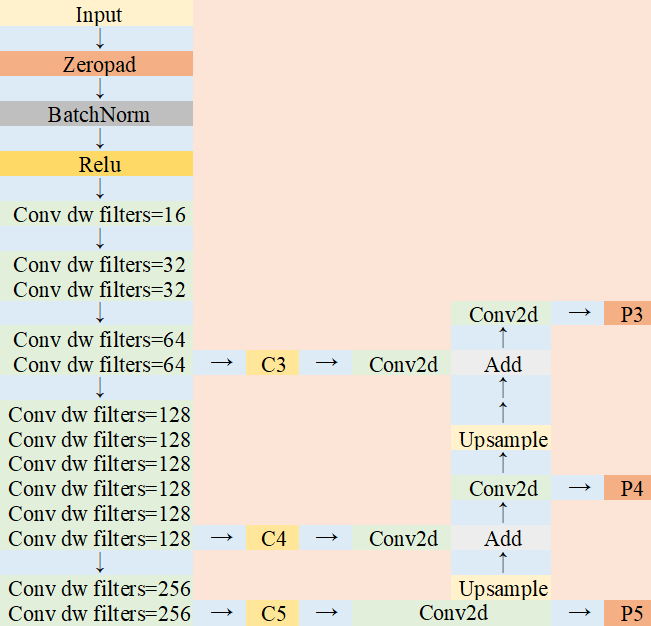

<Figure size 432x288 with 0 Axes>

In [5]:
img = Image.open('C:/Users/taoqi/Desktop/retina.png')
plt.figure('image')
display(img)

Let's reproduce the FPN code.

In [6]:
def conv_bn1X1(inp, oup, stride, leaky=0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, stride, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )

class FPN(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FPN,self).__init__()
        leaky = 0
        if (out_channels <= 64):
            leaky = 0.1
        self.output1 = conv_bn1X1(in_channels_list[0], out_channels, stride = 1, leaky = leaky)
        self.output2 = conv_bn1X1(in_channels_list[1], out_channels, stride = 1, leaky = leaky)
        self.output3 = conv_bn1X1(in_channels_list[2], out_channels, stride = 1, leaky = leaky)

        self.merge1 = conv_bn(out_channels, out_channels, leaky = leaky)
        self.merge2 = conv_bn(out_channels, out_channels, leaky = leaky)

    def forward(self, inputs):
        #-------------------------------------------#
        #   Obtain three effective feature layers
        #         C3  80, 80, 64
        #         C4  40, 40, 128
        #         C5  20, 20, 256
        #-------------------------------------------#
        inputs = list(inputs.values())

        #-------------------------------------------#
        #   Obtain three effective feature layers
        #         output1  80, 80, 64
        #         output2  40, 40, 64
        #         output3  20, 20, 64
        #-------------------------------------------#
        output1 = self.output1(inputs[0])
        output2 = self.output2(inputs[1])
        output3 = self.output3(inputs[2])

        #-------------------------------------------#
        #   output3 is fused with output2 by upsampling
        #   output2  40, 40, 64
        #-------------------------------------------#
        up3 = F.interpolate(output3, size=[output2.size(2), output2.size(3)], mode="nearest")
        output2 = output2 + up3
        output2 = self.merge2(output2)

        #-------------------------------------------#
        #   output2 is fused with output1 by upsampling
        #   output1  80, 80, 64
        #-------------------------------------------#
        up2 = F.interpolate(output2, size=[output1.size(2), output1.size(3)], mode="nearest")
        output1 = output1 + up2
        output1 = self.merge1(output1)

        out = [output1, output2, output3]
        return out

### SSH enhances feature extraction

In the previous step, we obtained three effective feature layers P3, P4, and P5. In order to further enhance feature extraction, Retinaface uses the SSH module to enhance the receptive field. SSH is structured as follows

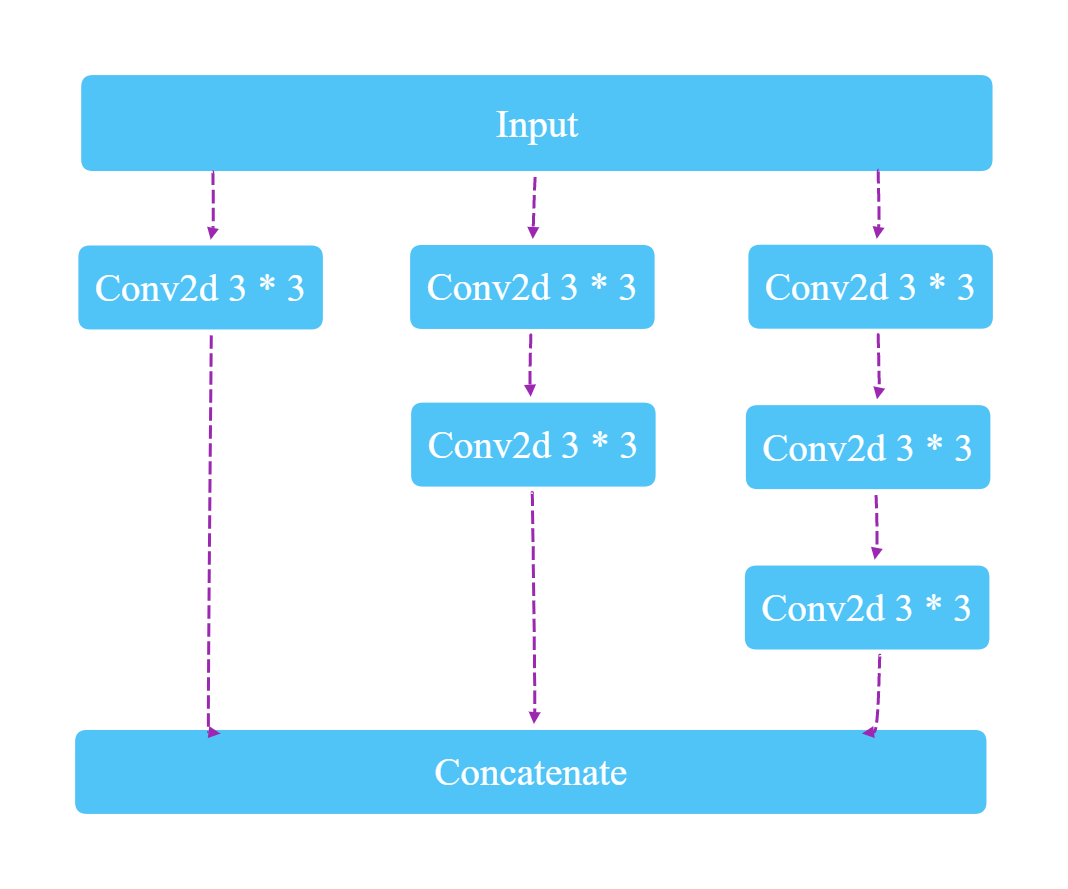

<Figure size 432x288 with 0 Axes>

In [6]:
img = Image.open('C:/Users/taoqi/Desktop/Input.png')
plt.figure('image')
display(img)

The idea of SSH is to simulate convolution. It uses three parallel structures and uses two 3 * 3 convolutions to simulate a 5 * 5 convolution. Use three 3 * 3 convolutions to simulate a 7 * 7 convolution.

Let's reproduce the SSH code.

In [7]:
#---------------------------------------------------#
#   convolution block
#   Conv2D + BatchNormalization + LeakyReLU
#---------------------------------------------------#
def conv_bn(inp, oup, stride = 1, leaky = 0):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.LeakyReLU(negative_slope=leaky, inplace=True)
    )


#---------------------------------------------------#
#   convolution block
#   Conv2D + BatchNormalization
#---------------------------------------------------#
def conv_bn_no_relu(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
    )


class SSH(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SSH, self).__init__()
        assert out_channel % 4 == 0
        leaky = 0
        if (out_channel <= 64):
            leaky = 0.1

        # 3 x 3 convolution
        self.conv3X3 = conv_bn_no_relu(in_channel, out_channel//2, stride=1)

        # Replace 5x5 convolution with two 3x3 convolutions
        self.conv5X5_1 = conv_bn(in_channel, out_channel//4, stride=1, leaky = leaky)
        self.conv5X5_2 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

        # Replace 7x7 convolutions with three 3x3 convolutions
        self.conv7X7_2 = conv_bn(out_channel//4, out_channel//4, stride=1, leaky = leaky)
        self.conv7x7_3 = conv_bn_no_relu(out_channel//4, out_channel//4, stride=1)

    def forward(self, inputs):
        conv3X3 = self.conv3X3(inputs)

        conv5X5_1 = self.conv5X5_1(inputs)
        conv5X5 = self.conv5X5_2(conv5X5_1)

        conv7X7_2 = self.conv7X7_2(conv5X5_1)
        conv7X7 = self.conv7x7_3(conv7X7_2)
        
        # stack all results
        out = torch.cat([conv3X3, conv5X5, conv7X7], dim=1)
        out = F.relu(out)
        return out

### Model's predictions

As we can see from the paper, the output of the model is a 16 * num anchors matrix. Among them, num anchors represents the number of anchors in each grid. In the paper, the author uses 2 squares as anchors.

First of all, as can be seen from the figure, the first two dimensions of the output are the classification results, which represent whether the image contains a face. 

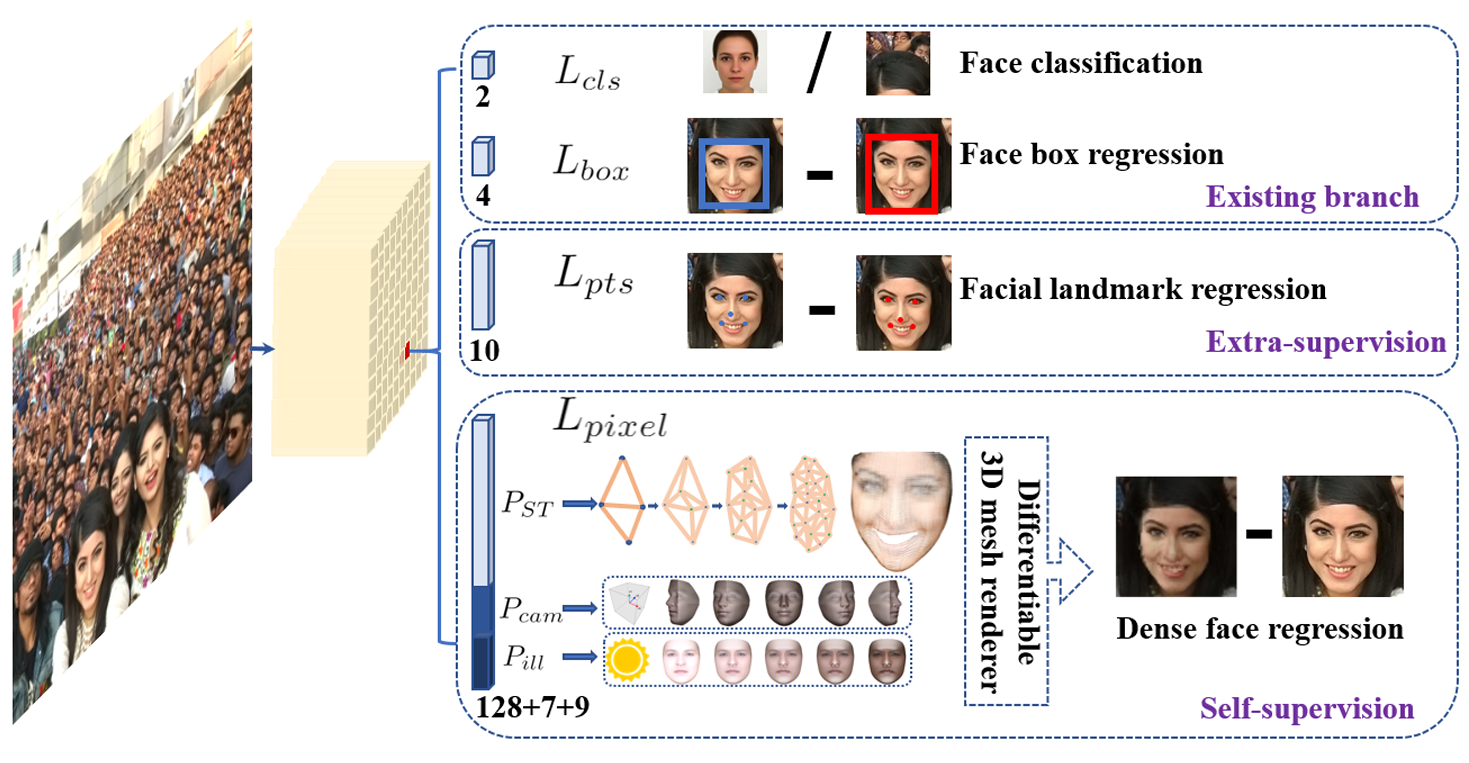

<Figure size 432x288 with 0 Axes>

In [8]:
img = Image.open('C:/Users/taoqi/Desktop/retinaface.png')
plt.figure('image')
display(img)

The next 4 dimensions represent the center point coordinates(first two dimensions) and width and height(last two dimensions) of the face prediction box.

The last 10 (5 * 2) dimensions represent the key point parameters of the face, representing the adjustment parameters of the eyes, nose and mouth respectively.

When the model completes the prediction, there will be many boxes on the original image. This is because a face will occupy multiple grids, each of which will output a result. In this case, we need to use non-maximum suppression. Choose the maximum value of the IOU for the prediction box. Finally, we use OpenCV to draw face prediction boxes on the original image.

### RetinaFace

In [ ]:
class RetinaFace(nn.Module):
    def __init__(self, cfg = None, pretrained = False, mode = 'train'):
        super(RetinaFace,self).__init__()
        backbone = None
        #-------------------------------------------#
        #   We use MobileNet as the backbone.
        #-------------------------------------------#
        if cfg['name'] == 'mobilenet0.25':
            backbone = MobileNetV1()
            if pretrained:
                checkpoint = torch.load("./model_data/mobilenetV1X0.25_pretrain.tar", map_location=torch.device('cpu'))
                from collections import OrderedDict
                new_state_dict = OrderedDict()
                for k, v in checkpoint['state_dict'].items():
                    name = k[7:]
                    new_state_dict[name] = v
                backbone.load_state_dict(new_state_dict)

        self.body = _utils.IntermediateLayerGetter(backbone, cfg['return_layers'])

        #-------------------------------------------#
        #   Obtain the number of channels per initial effective feature layer
        #-------------------------------------------#
        in_channels_list = [cfg['in_channel'] * 2, cfg['in_channel'] * 4, cfg['in_channel'] * 8]
        #-------------------------------------------#
        #   We use feature maps to build feature pyramids
        #-------------------------------------------#
        self.fpn = FPN(in_channels_list, cfg['out_channel'])
        #-------------------------------------------#
        #   We use the ssh module to increase the model's receptive field.
        #-------------------------------------------#
        self.ssh1 = SSH(cfg['out_channel'], cfg['out_channel'])
        self.ssh2 = SSH(cfg['out_channel'], cfg['out_channel'])
        self.ssh3 = SSH(cfg['out_channel'], cfg['out_channel'])

        self.ClassHead      = self._make_class_head(fpn_num=3, inchannels=cfg['out_channel'])
        self.BboxHead       = self._make_bbox_head(fpn_num=3, inchannels=cfg['out_channel'])
        self.LandmarkHead   = self._make_landmark_head(fpn_num=3, inchannels=cfg['out_channel'])

        self.mode = mode

    def _make_class_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        classhead = nn.ModuleList()
        for i in range(fpn_num):
            classhead.append(ClassHead(inchannels,anchor_num))
        return classhead
    
    def _make_bbox_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        bboxhead = nn.ModuleList()
        for i in range(fpn_num):
            bboxhead.append(BboxHead(inchannels,anchor_num))
        return bboxhead

    def _make_landmark_head(self,fpn_num=3,inchannels=64,anchor_num=2):
        landmarkhead = nn.ModuleList()
        for i in range(fpn_num):
            landmarkhead.append(LandmarkHead(inchannels,anchor_num))
        return landmarkhead

    def forward(self,inputs):
        #-------------------------------------------#
        #         C3  80, 80, 64
        #         C4  40, 40, 128
        #         C5  20, 20, 256
        #-------------------------------------------#
        out = self.body.forward(inputs)

        #-------------------------------------------#
        #         output1  80, 80, 64
        #         output2  40, 40, 64
        #         output3  20, 20, 64
        #-------------------------------------------#
        fpn = self.fpn.forward(out)

        feature1 = self.ssh1(fpn[0])
        feature2 = self.ssh2(fpn[1])
        feature3 = self.ssh3(fpn[2])
        features = [feature1, feature2, feature3]

        #-------------------------------------------#
        #   We stack all the results.
        #-------------------------------------------#
        bbox_regressions    = torch.cat([self.BboxHead[i](feature) for i, feature in enumerate(features)], dim=1)
        classifications     = torch.cat([self.ClassHead[i](feature) for i, feature in enumerate(features)], dim=1)
        ldm_regressions     = torch.cat([self.LandmarkHead[i](feature) for i, feature in enumerate(features)], dim=1)

        if self.mode == 'train':
            output = (bbox_regressions, classifications, ldm_regressions)
        else:
            output = (bbox_regressions, F.softmax(classifications, dim=-1), ldm_regressions)
        return output

### Experiment Results

The authors have tested the model on the WIDER FACE validation subset dataset. The experiments are shown in the table

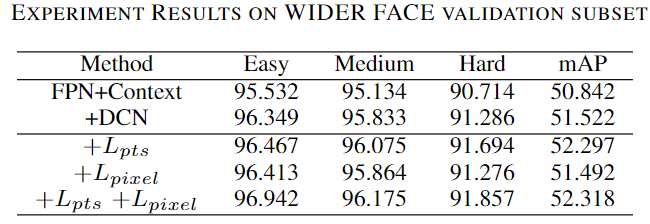

<Figure size 432x288 with 0 Axes>

In [9]:
img = Image.open('C:/Users/taoqi/Desktop/retinafaceacc.png')
plt.figure('image')
display(img)

The figure below is a sample output from Retinaface. The upper left corner of the blue face box is the probability of whether the box contains a face. As can be seen from the figure, the probability of being a face is 99.98%. The model performs well.

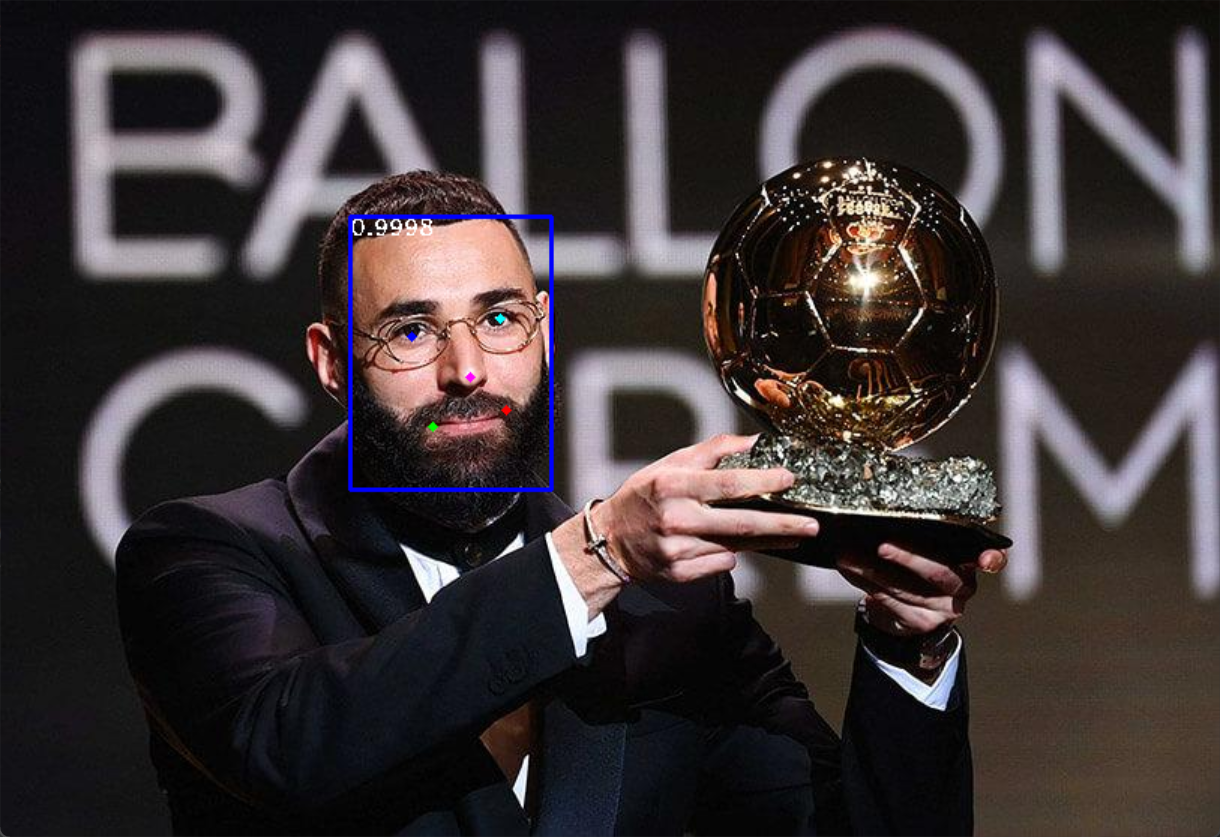

<Figure size 432x288 with 0 Axes>

In [10]:
if __name__ == "__main__":
    retinaface = Retinaface()
    #----------------------------------------------------------------------------------------------------------#
    #   'predict' means single image prediction
    #----------------------------------------------------------------------------------------------------------#
    mode = "predict"
    #----------------------------------------------------------------------------------------------------------#
    #   dir_origin_path specifies the folder path of the image used for detection
    #   dir_save_path specifies the save path of the detected image
    #-------------------------------------------------------------------------#
    dir_origin_path = "img/"
    dir_save_path   = "img_out/"

    if mode == "predict":
        #while True:
        img = 'img/benzema.jpg'
        image = cv2.imread(img)
        if image is None:
            print('Open Error! Try again!')
            #continue
        else:
            image   = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # r_image is the detected image, and lis is the face area of everyone in this image.
            r_image, lis = retinaface.detect_image(image)
            max_area = max(lis)
            # print(max_area)
            r_image = cv2.cvtColor(r_image, cv2.COLOR_RGB2BGR)
            cv2.imshow("after", r_image)
            cv2.waitKey(0)

## Face Recognition - FaceNet

### Introduce of few shot learning

In HW1 I learned few-shot learning. Few-shot learning is designed to deal with insufficient samples. For example, it is impossible for us to upload hundreds of photos of the same person to the model. The idea of few-shot learning is to pre-train on a large-scale dataset to obtain a feature representation (a feature vector). Then use 1-5 training samples to train the model. When predicting, we feed the predicted samples into the same network and also get a column vector. At this point we check the distance between the two vectors. If the distance is less than the threshold, we consider the recognition successful.

### Introduce of FaceNet

FaceNet is a face recognition algorithm proposed by Google in 2015. FaceNet utilizes the invariance of the same face at different angles, different lighting, and different poses to complete the model design. After it was released, it was SOTA at that time. It can achieve 99.63% accuracy on LFW dataset.

As described in the previous subsection, the model encodes an image as a 128-dimensional column vector. In order to facilitate the comparison later, we will also use L2 normalization, so that the feature vectors of different faces can belong to the same order of magnitude.

### Face capture and alignment

First of all, as mentioned in the previous chapter, we first use RetinaFace to get the position coordinates of the face prediction frame and the human eye. We observed that the faces are not always vertical in the photos taken, and sometimes the faces are crooked. At this point we need to align it. We obtain the angle between the line connecting the two eyes and the horizontal plane, and rotate the angle at the center coordinate of the prediction box to display the face vertically.

Our approach is to get: 

1. The angle of inclination of the line connecting the two eyes relative to the horizontal.
2. The center of the image.

We rotate the center of the image to get the aligned face, As shown in the figure.

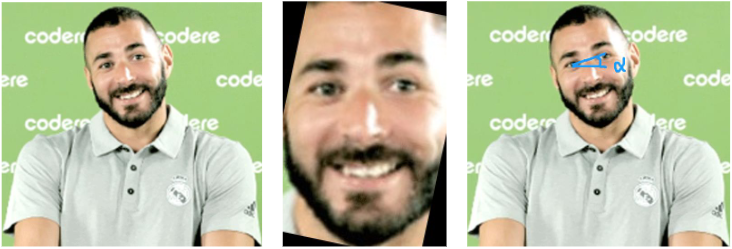

<Figure size 432x288 with 0 Axes>

In [3]:
img = Image.open('C:/Users/taoqi/Desktop/alignment.png')
plt.figure('image')
display(img)

### FaceNet Architecture

The FaceNet architecture is shown in Figure. The author uses InceptionNet as the backbone in the paper. Considering the inference speed, I still use MobileNetV1-0.25 as the backbone of the network.

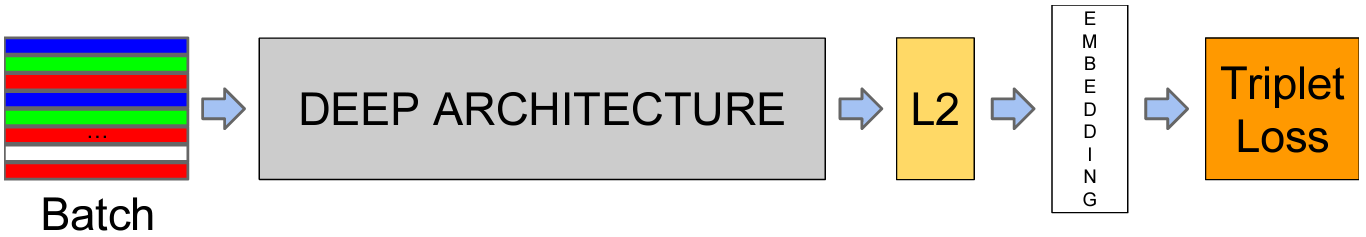

<Figure size 432x288 with 0 Axes>

In [5]:
img = Image.open('C:/Users/taoqi/Desktop/facenet.png')
plt.figure('image')
display(img)

### Face Comparison

As with few shot learning, instead of judging the class of an object, we check whether two objects are the same object. Analogy to this idea, in FaceNet, when we know a face picture, we need to check whether the second picture and the first picture are the same person, instead of caring who this person is.
1. Feed all known faces into the model for encoding, and call these vectors the database.
2. Feed all unknown faces (people to be recognized) into the model for encoding.
3. The vectors of unknown faces (people to be recognized) are compared with the vectors in the database.
4. Get the distance of each pair of vectors by circular comparison and find the minimum distance.
5. If the minimum value is less than the threshold, That is, we find the correct face.

The flow chart is shown in Figure

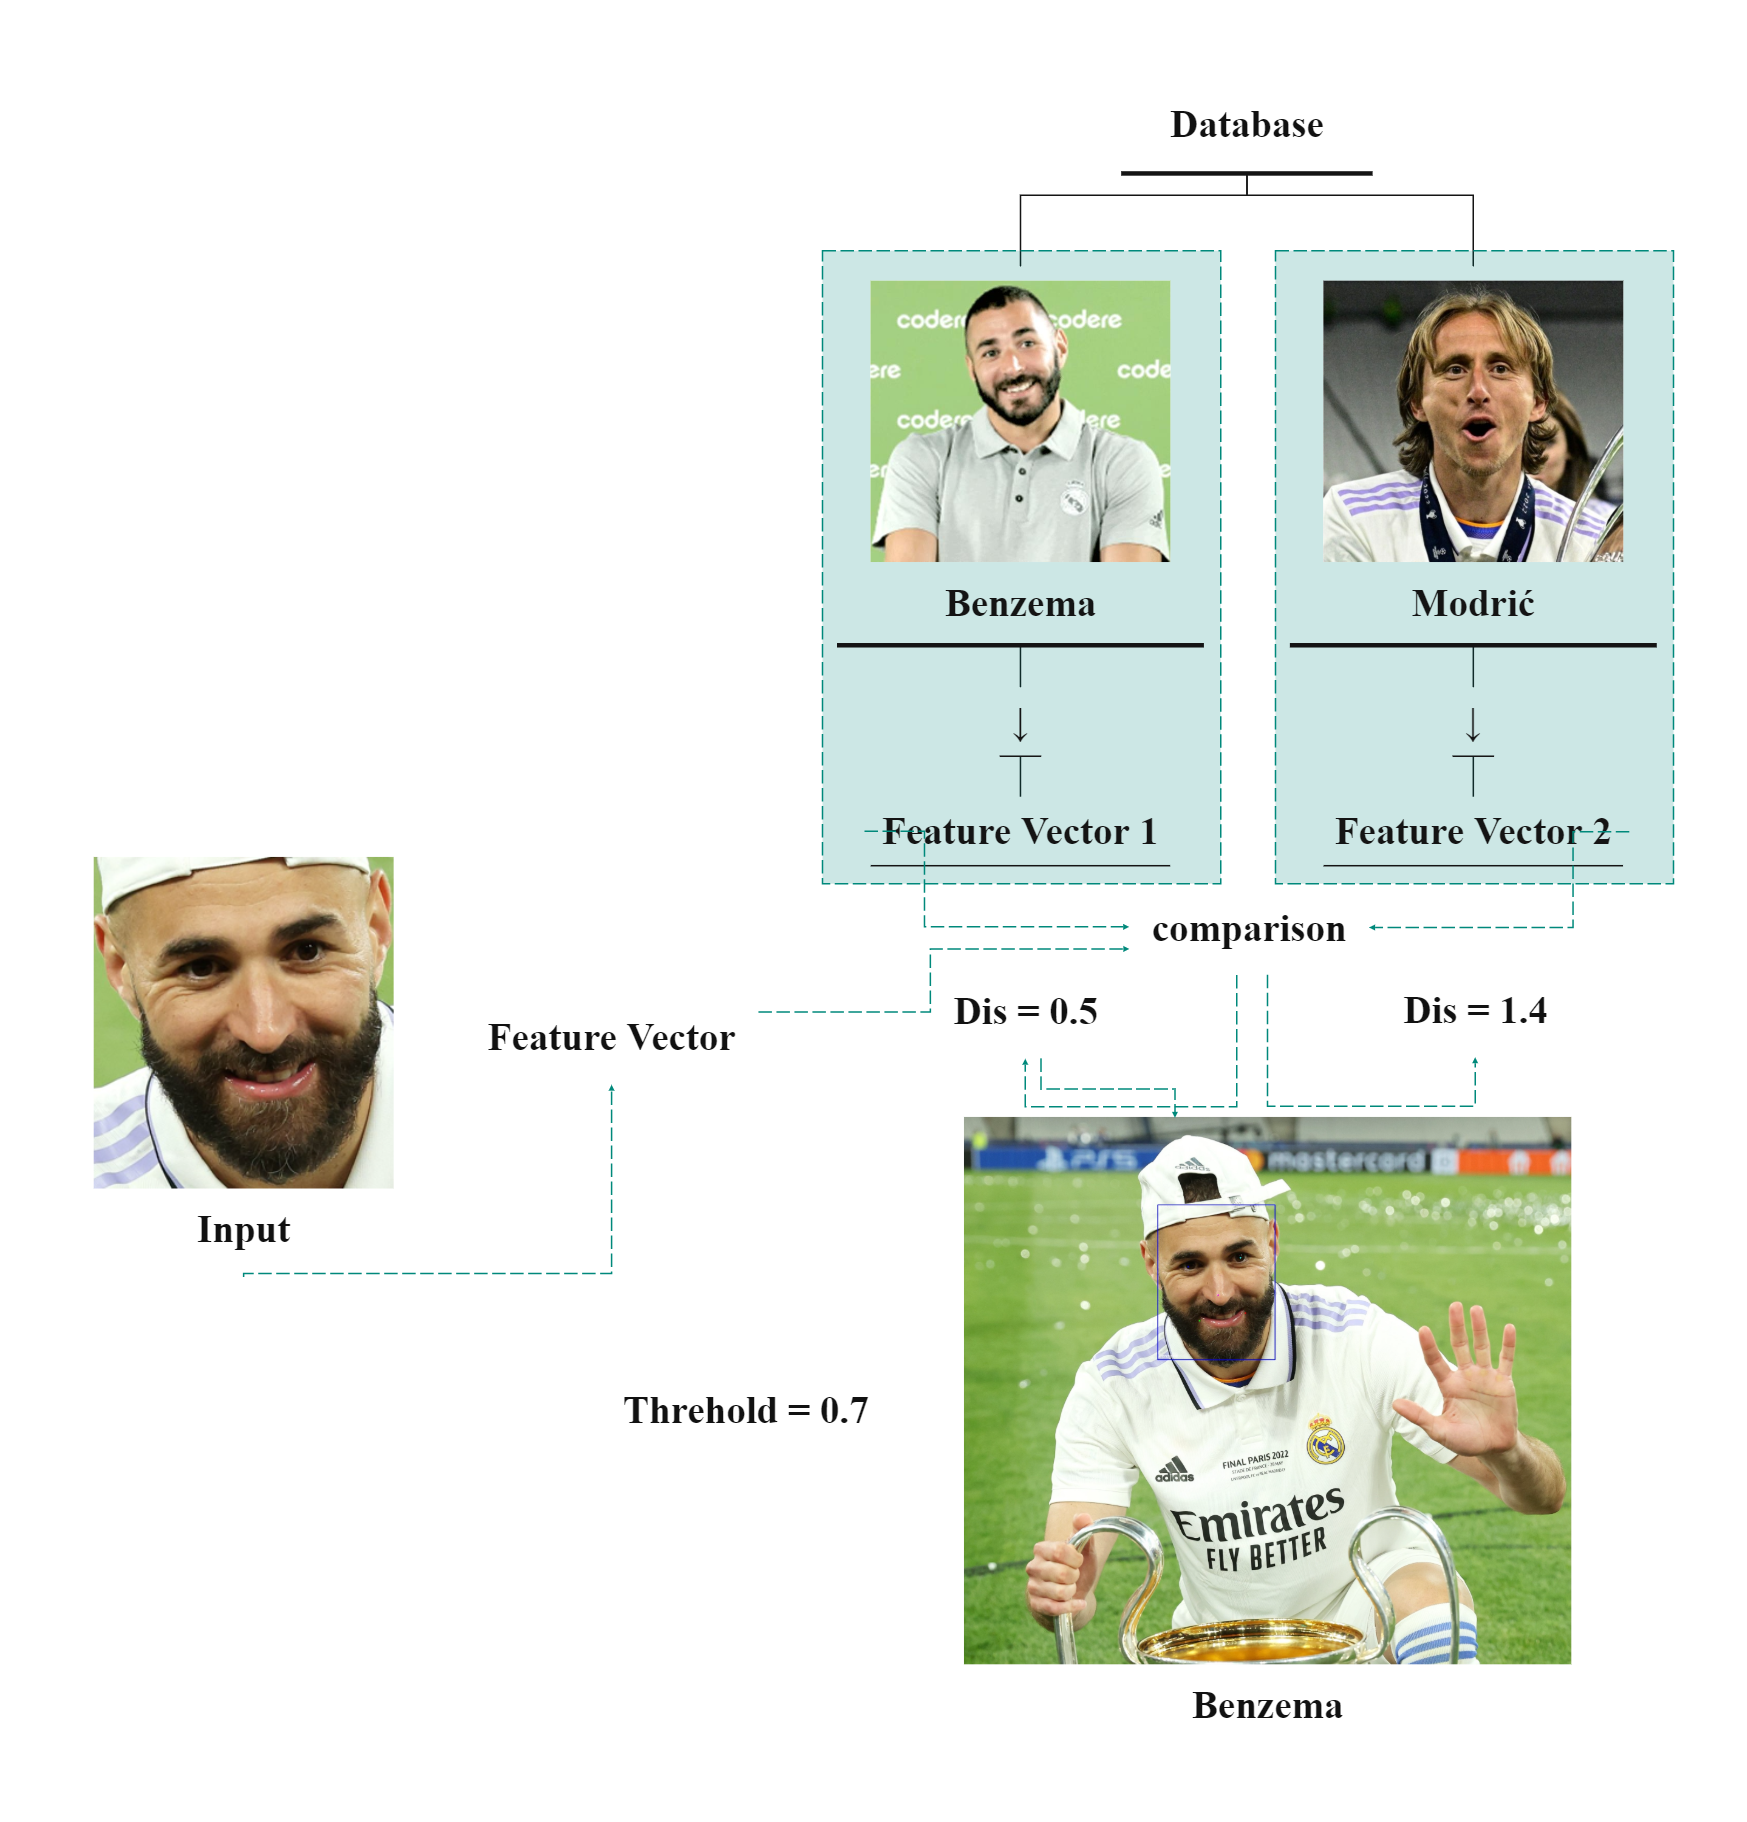

<Figure size 432x288 with 0 Axes>

In [6]:
img = Image.open('C:/Users/taoqi/Desktop/database.png')
plt.figure('image')
display(img)

In [ ]:
for face_encoding in face_encodings:
    #-----------------------------------------------------#
    #  Take a face and compare it with all faces in the database to calculate the score
    #-----------------------------------------------------#
    matches, face_distances = compare_faces(self.known_face_encodings, face_encoding, tolerance = self.facenet_threhold)
    name = "Unknown"
    #-----------------------------------------------------#
    #   Get the score of this nearest face
    #-----------------------------------------------------#
    # Argim gets the index of the minimum distance, returns matches to find the label
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]: 
        name = self.known_face_names[best_match_index]
    face_names.append(name)
    #print(face_names)

### FaceNet

In [ ]:
class Facenet(nn.Module):
    def __init__(self, backbone="mobilenet", dropout_keep_prob=0.5, embedding_size=128, num_classes=None, mode="train"):
        super(Facenet, self).__init__()
        if backbone == "mobilenet":
            self.backbone = mobilenet()
            flat_shape = 1024
        else:
            raise ValueError('Unsupported backbone - `{}`, Use mobilenet, inception_resnetv1.'.format(backbone))
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.Dropout = nn.Dropout(1 - dropout_keep_prob)
        self.Bottleneck = nn.Linear(flat_shape, embedding_size,bias=False)
        self.last_bn = nn.BatchNorm1d(embedding_size, eps=0.001, momentum=0.1, affine=True)
        if mode == "train":
            self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.Dropout(x)
        x = self.Bottleneck(x)
        x = self.last_bn(x)
        x = F.normalize(x, p=2, dim=1)
        return x

    def forward_feature(self, x):
        x = self.backbone(x)
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.Dropout(x)
        x = self.Bottleneck(x)
        before_normalize = self.last_bn(x)
        x = F.normalize(before_normalize, p=2, dim=1)
        return before_normalize, x

    def forward_classifier(self, x):
        x = self.classifier(x)
        return x

### Experiments

The authors did model evaluation on the LFW (Labeled Faces in the Wild) and YouTube Faces DB datasets., and Table shows the experimental results. From the results, FaceNet has good performance. The model has achieved 99% accuracy on the large-scale face dataset Labeled Faces in the Wild. The model also has 95% accuracy on YouTube Faces DB.

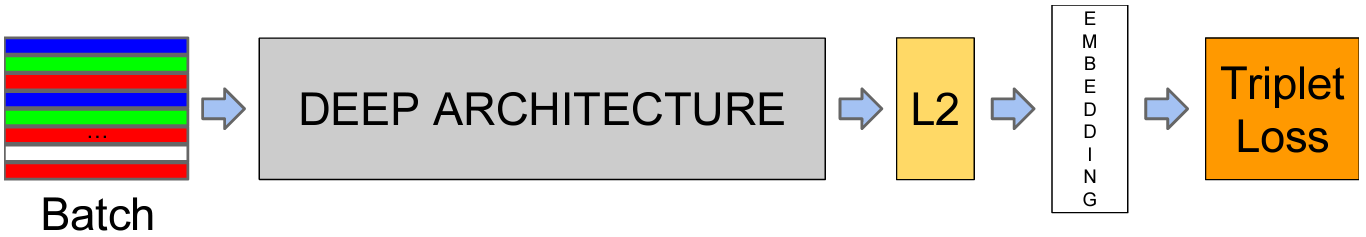

<Figure size 432x288 with 0 Axes>

In [7]:
img = Image.open('C:/Users/taoqi/Desktop/facenet.png')
plt.figure('image')
display(img)

My predictions are as follows. The input to the model is an image. First we get the face prediction box through RetinaFace, then send the prediction box to FaceNet. In FaceNet, we first use the idea of few shot learning to do pre-training in the large-scale face data set LFW (Labeled Faces in the Wild) to learn the expression of features, and then generate a 128-dimensional column vector for the predicted image and then combine with Column vectors in the database are compared. I set the threshold to 0.7. When the distance between the two smallest vectors is less than 0.7, the model is considered to have recognized the correct face. The example experimental result is shown in Figure

Loading weights into state dict...
Finished!


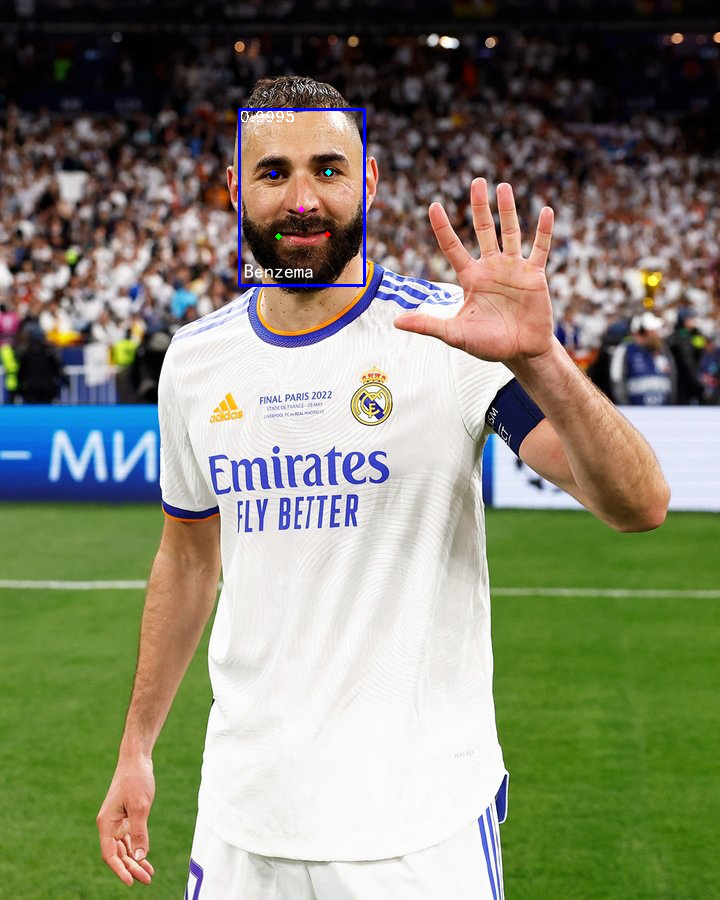

<Figure size 432x288 with 0 Axes>

In [3]:
import time
import tqdm as notebook_tqdm
import cv2
import numpy as np
from retinaface import Retinaface

retinaface = Retinaface()
# ----------------------------------------------------------------------------------------------------------#
#   mode is used to specify the mode of the test:
#   'predict' means single image prediction,
#   'video' means video detection, it can call camera or video for detection
# ----------------------------------------------------------------------------------------------------------#
mode = "predict"
# ----------------------------------------------------------------------------------------------------------#
#   video_path is used to specify the path of the video. When video_path=0, it means to use camera
#   video_save_path indicates the path where the video is saved
# ----------------------------------------------------------------------------------------------------------#
video_path = 0
video_save_path = "yyy.mp4"
video_fps = 25.0
test_interval = 100
dir_origin_path = "img/"
dir_save_path = "img_out/"

if mode == "predict":
    #while True:
        #img = input('Input image filename:')
        #print(img)
    image = cv2.imread('C:/Users/taoqi/PycharmProjects/facenet/facenet-retinaface-pytorch/img/ben9.jpg')
    if image is None:
        print('Open Error! Try again!')
        #continue
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        r_image = retinaface.detect_image(image)[0]
        r_image = cv2.cvtColor(r_image, cv2.COLOR_RGB2BGR)
        #cv2.imshow("after", r_image)
        cv2.imwrite('img/bb.jpg', r_image)
        img = Image.open('img/bb.jpg')
        # img.show() # 
        plt.figure('image')
        #plt.imshow(img)
        #plt.show()
        display(img)
        cv2.waitKey(0)

Now, we have successfully combined the two models together. But our goal is to do face recognition in video. So what's the difference between a video and each picture? Obviously, most videos are 30 frames per second, so we only need to extract each frame of the video and send it to the model, and finally combine the results, which completes our final goal.

In OpenCV, a function capture.read() is provided. It can analyze every frame in the video.

In [26]:
import time
import tqdm as notebook_tqdm
import cv2
import numpy as np
from retinaface import Retinaface

retinaface = Retinaface()
# ----------------------------------------------------------------------------------------------------------#
#   mode is used to specify the mode of the test:
#   'predict' means single image prediction,
#   'video' means video detection, it can call camera or video for detection
# ----------------------------------------------------------------------------------------------------------#
mode = "video"
# ----------------------------------------------------------------------------------------------------------#
#   video_path is used to specify the path of the video. When video_path=0, it means to use camera
#   video_save_path indicates the path where the video is saved
# ----------------------------------------------------------------------------------------------------------#
video_path = 0
video_save_path = "yyy.mp4"
video_fps = 25.0
test_interval = 100
dir_origin_path = "img/"
dir_save_path = "img_out/"

if mode == "predict":
    #while True:
        #img = input('Input image filename:')
        #print(img)
    image = cv2.imread('img/ben9.jpg')
    if image is None:
        print('Open Error! Try again!')
        #continue
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        r_image = retinaface.detect_image(image)[0]
        r_image = cv2.cvtColor(r_image, cv2.COLOR_RGB2BGR)
        cv2.imshow("after", r_image)
        cv2.imwrite('img/bb.jpg', r_image)
        cv2.waitKey(0)

elif mode == "video":
    capture = cv2.VideoCapture('C:/Users/taoqi/Desktop/test.mp4')
    if video_save_path != "":
        fourcc = cv2.VideoWriter_fourcc(*'FMP4')
        size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        out = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

    ref, frame = capture.read()
    if not ref:
        raise ValueError("The camera (video) cannot be read correctly, please check whether the camera is installed correctly (whether the video path is correctly filled in).")

    fps = 0.0
    num = 0
    n = []
    #q = ''
    res = False
    left = False
    temp = []
    # [100, 200]
    while (True):
        t1 = time.time()
        # read a frame
        ref, frame = capture.read()
        if not ref:
            break
        # Format conversion, BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # detect
        frame, q = retinaface.detect_image(frame)
        #print(q)
        frame = np.array(frame)
        if 'benzema' in q:
            res = True
        else:
            res = False
        #temp.append(res)
        #print(res)
        # results is intervals, such as [10, 16, 22, 28, 32, 40], which means in [[10, 16], [22, 28], [32,40]] frames detect that people
        if res and not left: # if we have not detected the left intervals
            left = True # we set left = True
            n.append(num) # just like 10, 22, 32(index % 2 == 0) in examples [10, 16, 22, 28, 32, 40]
        elif not res and left:
            n.append(num - 1)
            left = False # just like 16, 28, 40(index % 2 == 1) in examples [10, 16, 22, 28, 32, 40]
        '''
        elif res and left:
            if num == int(capture.get(7)) - 2:
                n.append(num)
        '''

        #print(name)
        # Format conversion, RGB to BGR
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        # Calculate FPS
        # Make sure not to divide by 0
        # print(time.time() - t1)
        a = time.time() - t1
        if a == 0:
            a = 0.0001
        fps = (fps + (1. / a)) / 2
        #print("fps= %.2f" % (fps))
        frame = cv2.putText(frame, "fps= %.2f" % (fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("video", frame)

        #print(num)
        c = cv2.waitKey(1) & 0xff
        if video_save_path != "":
            out.write(frame)

        if c == 27:
            capture.release()
            break
        num += 1
    #print(num)
    if res and left:
        n.append(int(capture.get(7)) - 2)
    lis = []
    #print(n)
    #print(int(capture.get(7)) - 1)
    left, right = 0, 1
    while left < len(n) - 1 and right < len(n):
        #lis.append(n[left])
        while right < len(n) - 2 and n[right] + 10 > n[right + 1]:
            right += 2
        lis.append([n[left], n[right]])
        left = right + 1
        right = left + 1
    print(lis)
    #print(len(temp))
    print("Video Detection Done!")
    capture.release()
    if video_save_path != "":
        print("Save processed video to the path :" + video_save_path)
        out.release()
    cv2.destroyAllWindows()

[[0, 40], [50, 90]]
Video Detection Done!


## REFERENCES

[1] Deng, Jiankang, et al. "Retinaface: Single-shot multi-level face localisation in the wild." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020.

[2] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

[3] Howard, Andrew G., et al. "Mobilenets: Efficient convolutional neural networks for mobile vision applications." arXiv preprint arXiv:1704.04861 (2017).

[4] C. C. Loy, D. Lin, W. Ouyang, Y. Xiong, S. Yang, Q. Huang, D. Zhou, W. Xia, Q. Li, P. Luo, et al. Wider face and pedestrian challenge 2018: Methods and results. arXiv:1902.06854, 2019.

[5] Schroff, Florian, Dmitry Kalenichenko, and James Philbin. "Facenet: A unified embedding for face recognition and clustering." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.